# 1. Introduction

## Estimators Library

In contextual bandits, a learning algorithm repeatedly observes a context, takes an action, and observes a reward for the chosen action. An example is content personalization: the context describes a user, actions are candidate stories, and the reward measures how much the user liked the recommended story. In essence, the algorithm is a policy that picks the best action given a context.

Given different policies, the metric of interest is their reward. One way to measure the reward is to deploy such policy online and let it choose actions (for example, recommend stories to users). However, such online evaluation can be costly for two reasons: It exposes users to an untested, experimental policy; and it doesn't scale to evaluating multiple target policies.

The alternative is off-policy evaluation: Given data logs collected by using a logging policy, off-policy evaluation can estimate the expected rewards for different target policies and provide confidence intervals around such estimates.

The estimators library collects estimators to perform such off-policy evaluation. 

This notebook is a concise walkthrough of the estimators library.



We start by importing from our estimator library

In [1]:
%load_ext autoreload
%autoreload 2

from vowpalwabbit import pyvw
import argparse, os, gzip

#Estimator library
import cressieread
import ips_snips
import mle
import ds_parse
import dr
import policy
import evaluation
import softening

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from scipy import spatial

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind", 10))

# 2. Logging Data

As in any machine learning/data science project, the first step is to load and massage your data in order to extract the appropriate features to use in your succeeding steps.

We are working with data from a logging policy, which we expect to be provided in  ```dsjson``` format. From this data, we then  extract our ```x```, ```a```,```r```, and ```p```. In this walkthrough, the data has been generated in a similar way with the <a href="https://vowpalwabbit.org/tutorials/cb_simulation.html">Simulating Content Personalization with Contextual Bandits tutorial</a>

Let's take a look at the input file:

In [2]:
!head -2 ../data/cpwcb.json

First, we have a convenience function called  ```parse_file``` from imported ```ds_parse``` module

In [3]:
#?ds_parse.parse_file

In [51]:
#data_file = "../data/cb_data.json"
log_data_file = "../data/cpwcb.json"
log_data_parsed = "../data/parsed_data.dat"

ds_parse.parse_file(log_data_file, log_data_parsed, True) #


Parsing file... Processing: ../data/cpwcb.json
Progress: [##################################################] 100.0%

Let's see how the parsed data looks by printing a few lines in the resulting file:

In [52]:
!head -2 ../data/parsed_data.dat

# 3. Estimators Description

### Estimators implemented in estimators library
- ```ips``` - IPS
- ```snips``` - SNIPS
- ```mle``` - MLE
- ```cressieread``` - CRESSIE READ
- ```dr_batch``` - DOUBLY ROBUST in Batch Mode
- ```dr_online``` - DOUBLY ROBUST in Online Mode 
- ```dr_seq_batch``` - DOUBLY ROBUST SEQUENTIAL in Batch Mode
- ```dr_seq_online``` - DOUBLY ROBUST SEQUENTIAL in Online Mode

- ```pseudo_inverse``` - PSEUDO INVERSE*

### Description of implemented modules
- ```Evaluation.py``` - provides interface for interacting with the implemented estimators. It provides for evaluating the expected reward, comparing performance of estimators and other related tasks
- ```softening.py``` - provides functionalities related to softening and transforming a Classification dataset to a CB dataset
- ```policy.py``` - provides capabilities for invoking policies including custom VW policies

Current notebook provides usage examples

# 4. Evaluation and Comparison

List containing the Policies that we may want to evaluate as well as the estimators to be used.

Policies and estimators are provided as strings as specified

In [53]:
policies = ['Constant', 'UniformRandom']
estimators = ['snips','ips', 'dr_batch', 'dr_online', 'mle','cressieread']#'dr_seq_batch', 'dr_seq_batch']

In [54]:
#New plotting function with bigger figure size and with legends
plt.rcParams["figure.figsize"] = (15, 10)
def plot_expectedr(title, expectedr, label):
    plt.plot(range(1,len(expectedr)+1), expectedr, label=label)
    plt.grid()
    plt.xlabel('samples', fontsize=14)
    plt.ylabel('expected reward', fontsize=14)
    plt.title(title)
    plt.ylim([0, 1])
    plt.xlim([0, len(expectedr)])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=2)
    #plt.legend(loc="upper right")

## Usage Scenarios

## 4.1. Evaluation
#### 4.1.1. Evaluating the estimated expected reward of one target policy for one estimator

In [55]:
#?evaluation.compute_estimate

	Expected reward:  0.1432369325175987


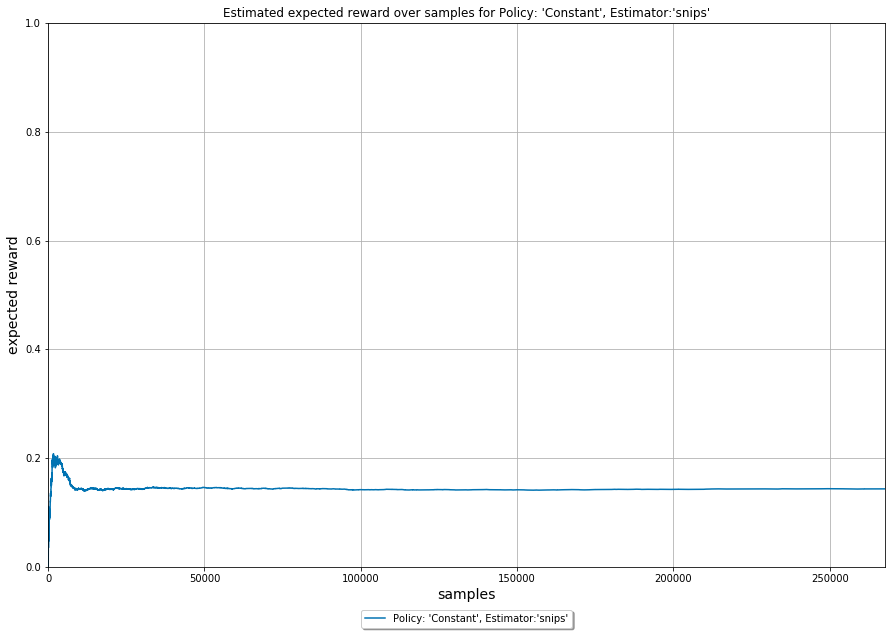

In [56]:
estimated_rewards = evaluation.compute_estimate('UniformRandom', 'snips', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: 'Constant', Estimator:'snips'", estimated_rewards, "Policy: 'Constant', Estimator:'snips'")

#### 4.1.2 Evaluating the estimated expected reward of one target policy and one estimator for dr-based estimators

For this, we have implemented the reward predictor for DR-based methods using Vowpal Wabbit

##### dr_online

	Expected reward:  0.24600809676490898


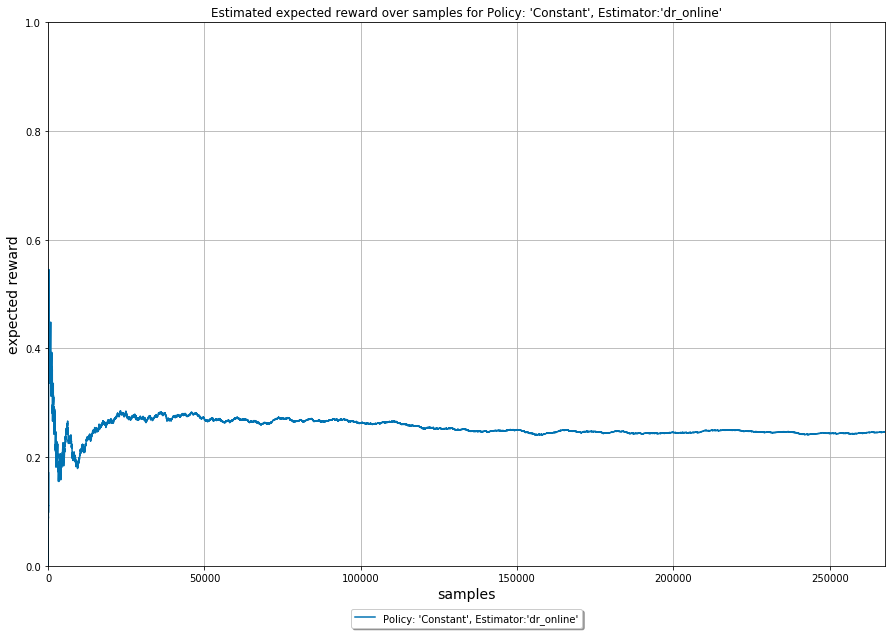

In [57]:
estimated_rewards = evaluation.compute_estimate_dr('Constant', 'dr_online', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: 'Constant', Estimator:'dr_online'", estimated_rewards, "Policy: 'Constant', Estimator:'dr_online'")

##### dr_batch

	Expected reward:  0.2458137307657858


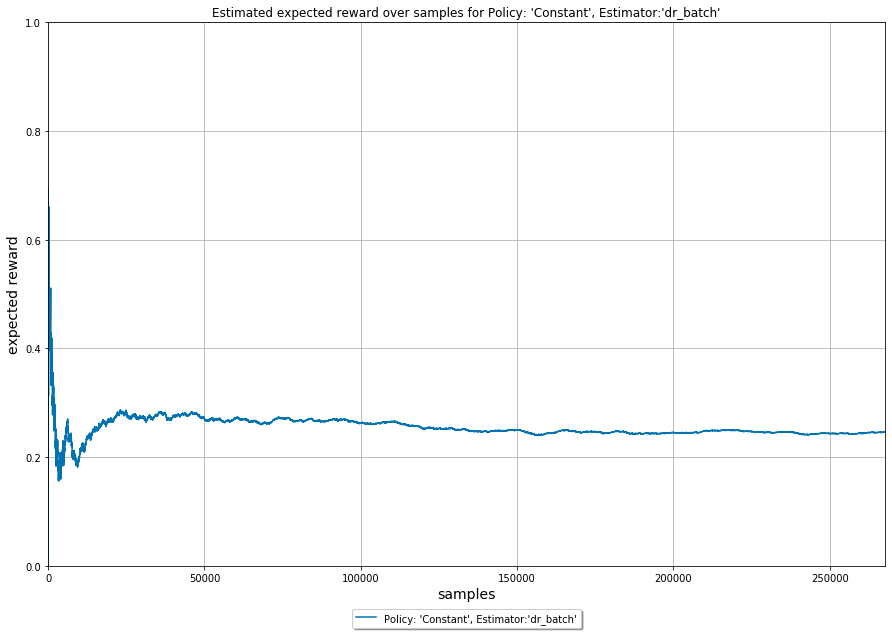

In [58]:
estimated_rewards = evaluation.compute_estimate_dr('Constant', 'dr_batch', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: 'Constant', Estimator:'dr_batch'", estimated_rewards, "Policy: 'Constant', Estimator:'dr_batch'")

### Support for scikit-learn for the reward predictor in DR-based methods

We First need to a Pandas Dataframe for the data.

We have another utility function ```create_json``` for generating a json file from the parsed log data

In [12]:
#?ds_parse.create_json

In [13]:
log_data_json = "../data/parsed_data.json"
ds_parse.create_json(log_data_parsed, log_data_json)

Loading the file into a Pandas Dataframe to have a look:

In [14]:
# Load the JSON file into a data frame
df = pd.read_json(log_data_json, orient='columns')

# View the first rows
df.head()

,XNamespace,a,a_vec,c_time_of_day,c_user,cost,num_a,p,r,skipLearn
0,c_user: 0 c_time_of_day: 1,7,"[1, 2, 3, 4, 5, 6, 7]",1,0,0,7,0.142857,0,0
1,c_user: 0 c_time_of_day: 1,7,"[1, 2, 3, 4, 5, 6, 7]",1,0,0,7,0.142857,0,0
2,c_user: 1 c_time_of_day: 1,1,"[1, 2, 3, 4, 5, 6, 7]",1,1,-1,7,0.142857,1,0
3,c_user: 1 c_time_of_day: 0,2,"[1, 2, 3, 4, 5, 6, 7]",0,1,-1,7,0.028571,1,0
4,c_user: 1 c_time_of_day: 0,5,"[1, 2, 3, 4, 5, 6, 7]",0,1,0,7,0.028571,0,0


To train doubly robust based methods with scikit-learn, you need to ensure that 
1. You provide a dataframe as the data file
2. The argument ```clf``` to the ```compute_estimate_dr``` method, supports <a href="https://scikit-learn.org/stable/modules/computing.html#incremental-learning">scikit-learn's incremental learning</a>. The default is ```SGDClassifier```.


##### dr_batch with scikit

	Expected reward:  [0.1698362]


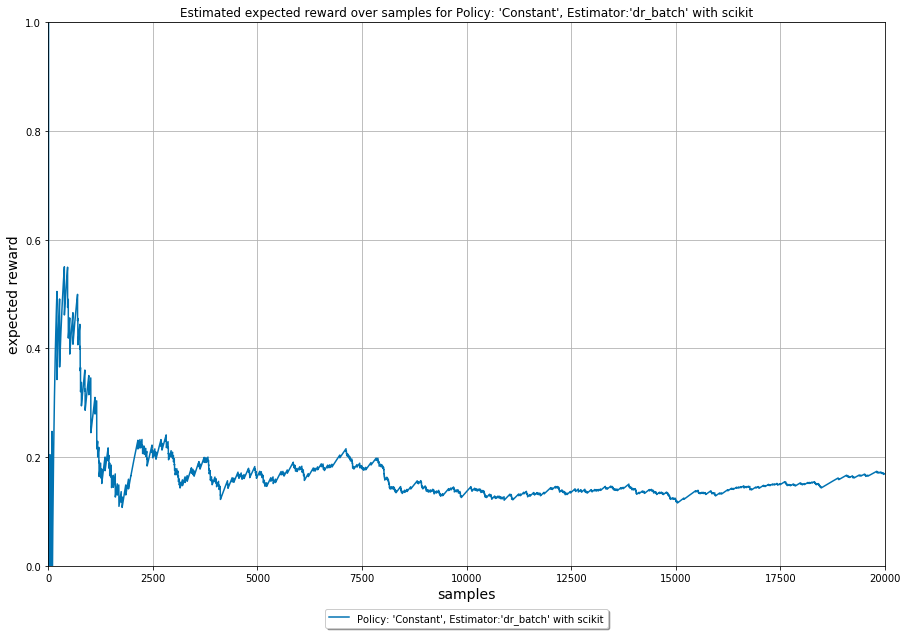

In [15]:
clf = linear_model.Perceptron(tol=1e-3, random_state=0)

estimated_rewards = evaluation.compute_estimate_dr('Constant', 'dr_batch', df, scikit=True, clf=clf)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: 'Constant', Estimator:'dr_batch' with scikit", estimated_rewards, "Policy: 'Constant', Estimator:'dr_batch' with scikit")

##### dr_online with scikit

	Expected reward:  [0.17130511]


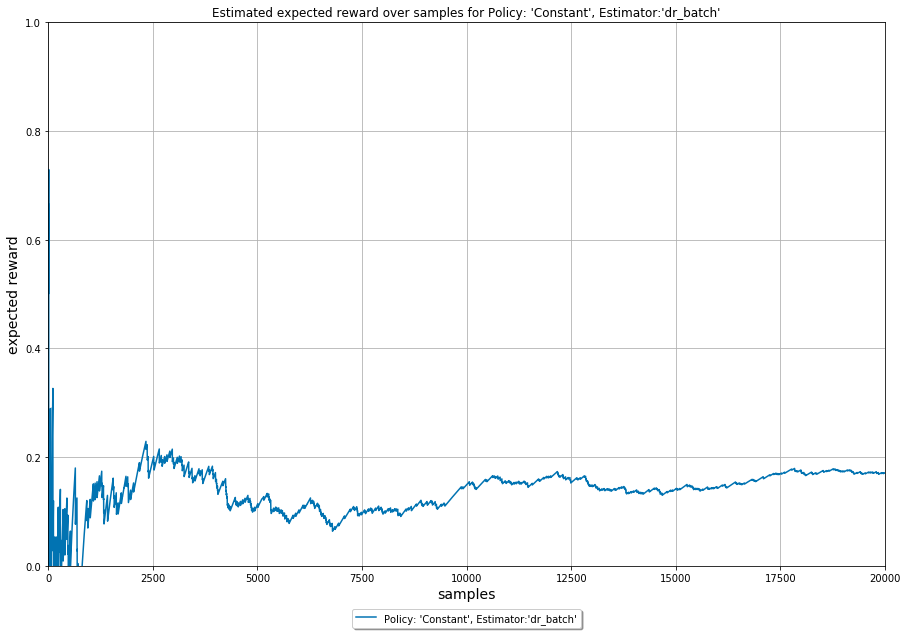

In [16]:
clf = linear_model.Perceptron(tol=1e-3, random_state=0)

estimated_rewards = evaluation.compute_estimate_dr('Constant', 'dr_online', df, scikit=True, clf=clf, load_pretrained_model=False)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: 'Constant', Estimator:'dr_batch'", estimated_rewards, "Policy: 'Constant', Estimator:'dr_batch'")

## 4.2. Support for Custom VW Policies 

In this section, we add support for custom VW generated policies.

Here, you can learn a custom policy using ```--cb_explore```

	Expected reward:  0.9546195457259233


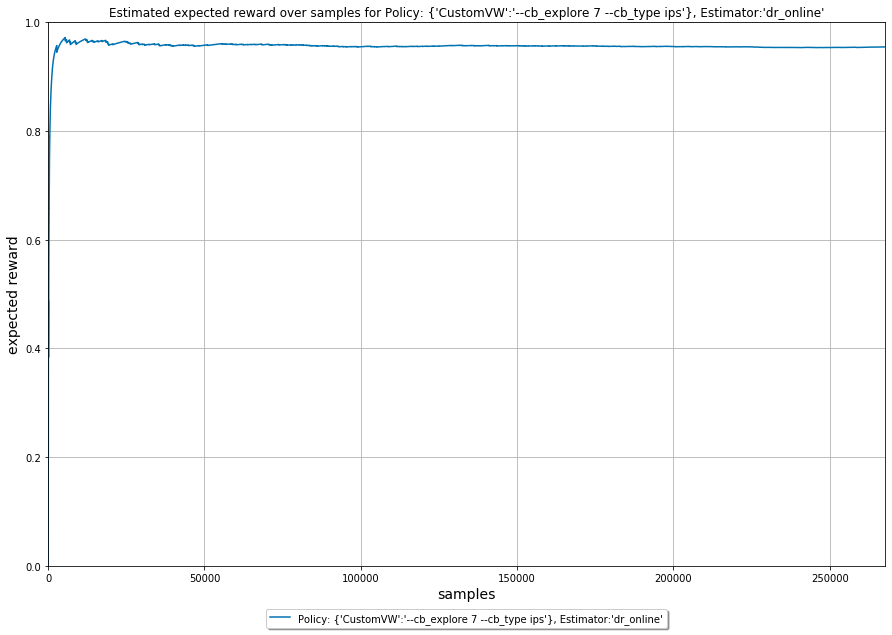

In [59]:
policy_vw_string='--cb_explore 7 --cb_type ips'

estimated_rewards = evaluation.compute_estimate({'CustomVW':policy_vw_string}, 'snips', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: {'CustomVW':'--cb_explore 7 --cb_type ips'}, Estimator:'dr_online'", estimated_rewards, "Policy: {'CustomVW':'--cb_explore 7 --cb_type ips'}, Estimator:'dr_online'")

	Expected reward:  0.9556278620509878


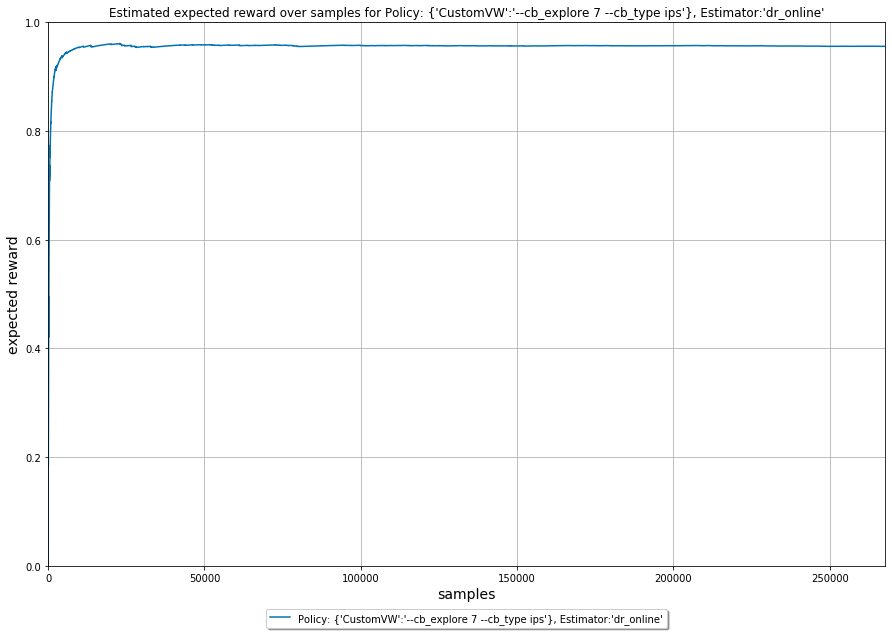

In [60]:
policy_vw_string='--cb_explore 7 --cb_type ips'

estimated_rewards = evaluation.compute_estimate_dr({'CustomVW':policy_vw_string}, 'dr_online', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: {'CustomVW':'--cb_explore 7 --cb_type ips'}, Estimator:'dr_online'", estimated_rewards, "Policy: {'CustomVW':'--cb_explore 7 --cb_type ips'}, Estimator:'dr_online'")

	Expected reward:  0.8232294257263666


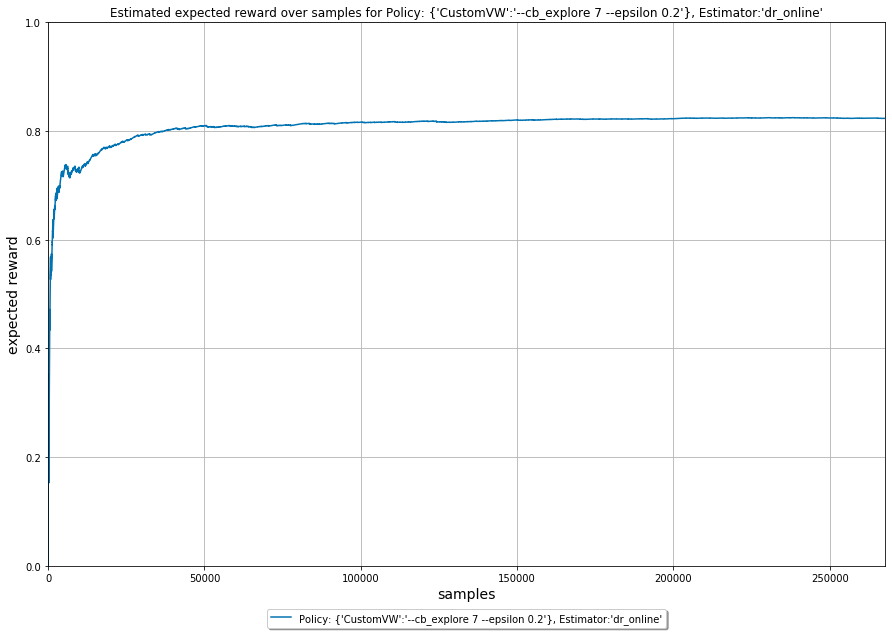

In [61]:
policy_vw_string='--cb_explore 7 --epsilon 0.2'

estimated_rewards = evaluation.compute_estimate_dr({'CustomVW':policy_vw_string}, 'dr_online', log_data_parsed)
print("\tExpected reward: ", estimated_rewards[-1])
plot_expectedr("Estimated expected reward over samples for Policy: {'CustomVW':'--cb_explore 7 --epsilon 0.2'}, Estimator:'dr_online'", estimated_rewards, "Policy: {'CustomVW':'--cb_explore 7 --epsilon 0.2'}, Estimator:'dr_online'")

## 4.3. Comparison of Policies and Estimators 

#### 4.3.1. Comparing the the estimated expected reward of one target policy over a set of estimators

In [62]:
def visualize_comparison(results):
    plt.figure(1)
    plt.grid()
    for res in results:
        plot_expectedr('Comparison of performance over different policies and estimators', res['estimates'], "Policy: "+str(res['policy'])+", Estimator: "+str(res['estimator']))

In [63]:
#?evaluation.compare

	Policy:  Constant
		snips:	 0.2501682532525464
		ips:	 0.25169017253762
		dr_batch:	 0.2458137307657858
		dr_online:	 0.24600809676490898
	Best result: 
		policy: Constant 
		estimator: ips 
		estimate: 0.25169017253762


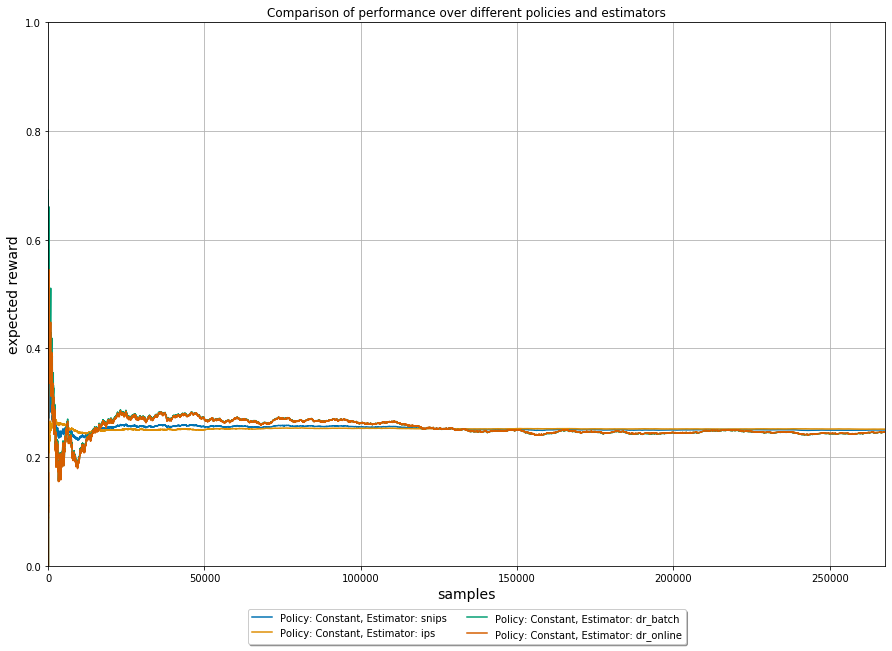

In [64]:
estimators = ['snips','ips', 'dr_batch', 'dr_online']#, 'mle','cressieread','dr_seq_batch', 'dr_seq_batch']

best, results = evaluation.compare('Constant', estimators, log_data_parsed)

visualize_comparison(results)

#### 4.3.2. Comparing the estimated expected reward of a set of target policies using one estimator

	Policy:  Constant
		dr_online:	 0.24600809676490898
	Policy:  UniformRandom
		dr_online:	 0.14172350553392965
	Best result: 
		policy: Constant 
		estimator: dr_online 
		estimate: 0.24600809676490898


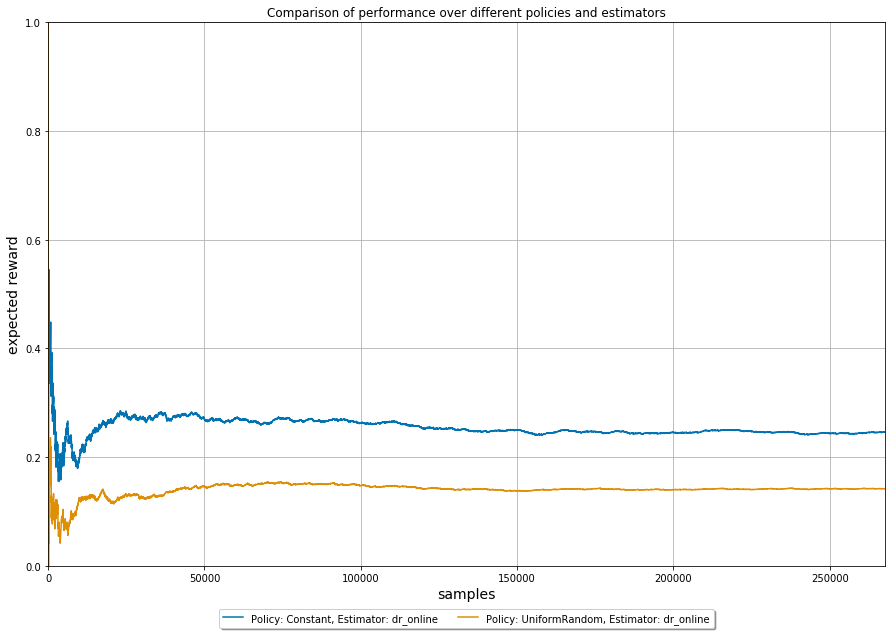

In [65]:
policies = ['Constant', 'UniformRandom']

best, results = evaluation.compare(policies, 'dr_online', log_data_parsed)

visualize_comparison(results)

#### 4.3.3. Comparing the estimated expected reward of a set of target policies over a set of estimators

	Policy:  Constant
		snips:	 0.2501682532525464
		ips:	 0.25169017253762
		dr_batch:	 0.2458137307657858
		dr_online:	 0.24600809676490898
	Policy:  UniformRandom
		snips:	 0.14478352554786503
		ips:	 0.14279318327096793
		dr_batch:	 0.14600336602577066
		dr_online:	 0.15215173370175333
	Policy:  {'CustomVW': '--cb_explore 7 --cb_type ips'}
		snips:	 0.956243162769107
		ips:	 0.9576677851573627
		dr_batch:	 0.9565441238330799
		dr_online:	 0.9570781569038105
	Policy:  {'CustomVW': '--cb_explore 7 --cb_type dm'}
		snips:	 0.9579884720826138
		ips:	 0.9549494176878724
		dr_batch:	 0.956398538863531
		dr_online:	 0.9548387794743484
	Best result: 
		policy: {'CustomVW': '--cb_explore 7 --cb_type dm'} 
		estimator: snips 
		estimate: 0.9579884720826138


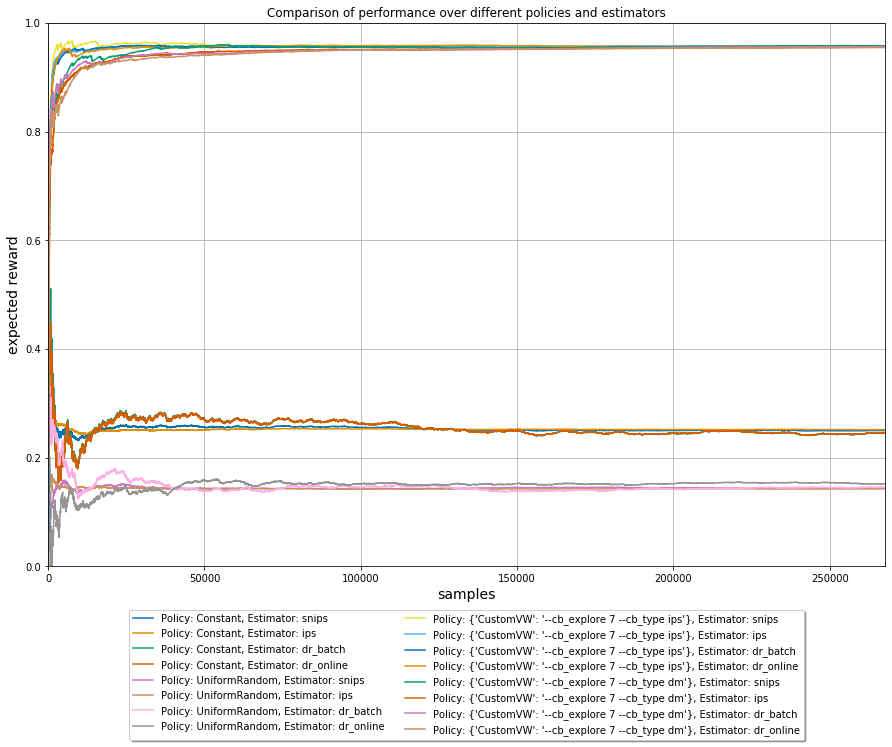

In [66]:
policies = ['Constant', 'UniformRandom', {'CustomVW':'--cb_explore 7 --cb_type ips'}, {'CustomVW':'--cb_explore 7 --cb_type dm'}]
estimators = ['snips','ips', 'dr_batch', 'dr_online']#, 'mle','cressieread','dr_seq_batch', 'dr_seq_batch']

best, results = evaluation.compare(policies, estimators, log_data_parsed)

visualize_comparison(results)

# 5. Generating a Contextual Bandit Dataset

Generating a random logging policy and target policy to use for evaluation

### 5.1. Training our classifier model  to generate a deterministic policy π



In [25]:
yeast_data = pd.read_csv('../data/yeast.data', delim_whitespace=True, header=None, names=['Sequence_Name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'Target'])  
X = yeast_data[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']]
Y = yeast_data[['Target']].astype("category")

test_size=0.3

clf=RandomForestClassifier(max_depth=5, n_estimators=10)

acc, action_num, act_gtruth, act, X_test=softening.train_target(X, Y, test_size, clf)

In [26]:
print('Model Accuracy: %.4f'%acc)
print('Action Number: %d'%action_num)

Model Accuracy: 0.5695
Action Number: 10


### 5.2. Softening our deterministic policy π

Softening is a method for transforming a deterministic policy into a stochastic policy

We support 3 different softening methods[1]:
- Neutral
- Friendly
- Adversarial

First instantiate the CBPolicy class from the ```softening``` module

In [27]:
cb_policy = softening.CBPolicy(action_num)

Next Soften by passing your desired softening parameters

### 5.2.1. Comparing softening methods


#### Neutral

In [28]:
soften_params = {'method':'neutral'
                }
act_prob_neutral = cb_policy.get_soften_action(act, soften_params)

Assessing similarity of softened actions with actions from deterministic policy:

In [29]:
1-spatial.distance.cosine(act_prob_neutral['action'][0], act)

0.6192216697359445

Computing the neutral softening reward:

In [30]:
neutral_r = softening.get_reward(act_prob_neutral['action'][0], act)

#### Friendly

In [31]:
soften_params = {'method':'friendly',
                 'alpha': 0.7,
                 'beta':0.2
                }
act_prob_friendly = cb_policy.get_soften_action(act, soften_params)

Assessing similarity of softened actions with actions from deterministic policy:

In [32]:
1-spatial.distance.cosine(act_prob_friendly['action'][0], act)

0.8602646160794079

Computing the friendly truth reward:

In [33]:
friendly_r = softening.get_reward(act_prob_friendly['action'][0], act)

#### Adversarial

In [34]:
soften_params = {'method':'adversarial',
                 'alpha': 0.5,
                 'beta':0.2
                }
act_prob_adv = cb_policy.get_soften_action(act, soften_params)

Assessing similarity of softened actions with actions from deterministic policy:

In [35]:
1-spatial.distance.cosine(act_prob_adv['action'][0], act)

0.6241456323671213

Computing the adversarial softening reward:

In [36]:
adversarial_r = softening.get_reward(act_prob_adv['action'][0], act)

### Putting it all together

To sum it up we need ```(x, a, r, p)``` for off-policy evaluation. 
Taking Friendly softening as our softening technique, we have these as follows:

```x```

In [37]:
X_test.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.42,0.31,0.62,0.12,0.5,0.0,0.40,0.22
1,0.69,0.50,0.49,0.42,0.5,0.0,0.49,0.22
2,0.46,0.38,0.47,0.22,0.5,0.0,0.52,0.27
3,0.55,0.59,0.47,0.64,0.5,0.0,0.54,0.33
4,0.41,0.48,0.54,0.24,0.5,0.0,0.37,0.51


```a```

In [38]:
act_prob_friendly['action'][0][:4]

array([0, 6, 6, 6])

```p```

In [39]:
act_prob_friendly['prob'][:4]

array([0.71743938, 0.64966372, 0.0242057 , 0.78724364])

action pdf

In [40]:
act_prob_friendly['prob_list'][:2]

[[0.7174393792990699,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557,
  0.03139562452232557],
 [0.03892625379120813,
  0.03892625379120813,
  0.03892625379120813,
  0.03892625379120813,
  0.03892625379120813,
  0.03892625379120813,
  0.6496637158791269,
  0.03892625379120813,
  0.03892625379120813,
  0.03892625379120813]]

```r```

In [41]:
friendly_r[:4]

array([1, 1, 0, 1])

### 5.3. Bringing it all together
#### Training, softening and generating a CB dataset from a classification dataset

In [42]:
yeast_data = pd.read_csv('../data/yeast.data', delim_whitespace=True, header=None, names=['Sequence_Name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'Target'])  
X = yeast_data[['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']]
Y = yeast_data[['Target']].astype("category")

test_size=0.3

clf=RandomForestClassifier(max_depth=5, n_estimators=10)
#clf=SVC(kernel="linear", C=0.025)
#clf=SVC(gamma=2, C=1)
#clf=GaussianProcessClassifier(1.0 * RBF(1.0))
#clf=DecisionTreeClassifier(max_depth=5)

accuracy, action_num, act_gtruth, act_deterministic, X_test=softening.train_target(X, Y, test_size, clf)

N=10000 #number of samples

soften_params_behaviour = {'method':'friendly',
                           'alpha': 0.9,
                           'beta':0.0
                          }

cb_policy = softening.CBPolicy(action_num)

#Generating Behaviour Data
out_behaviour_json = "../data/cb_behaviour_data.json"
X_context, a_det, a_gtruth = softening.classification_to_cb_behaviour(X_test, action_num, act_gtruth, act_deterministic, cb_policy, soften_params_behaviour, out_behaviour_json, N)

soften_params_evaluation1={'method':'neutral'}

soften_params_evaluation2={'method':'friendly',
                           'alpha': 0.7,
                           'beta':0.2
                          }

soften_params_evaluation3={'method':'adversarial',
                           'alpha': 0.5,
                           'beta':0.2
                           }

#Generating Evaluation Data ---Preserving context used in generating behaviour data
out_evaluation_json1 = "../data/cb_evaluation_data1.json"
r1 = softening.classification_to_cb_evaluation(X_context, action_num, np.array(a_gtruth, dtype=int), np.array(a_det, dtype=int), cb_policy, soften_params_evaluation1, out_evaluation_json1, N)

out_evaluation_json2 = "../data/cb_evaluation_data2.json"
r2 = softening.classification_to_cb_evaluation(X_context, action_num, np.array(a_gtruth, dtype=int), np.array(a_det, dtype=int), cb_policy, soften_params_evaluation2, out_evaluation_json2, N)

out_evaluation_json3 = "../data/cb_evaluation_data3.json"
r3 = softening.classification_to_cb_evaluation(X_context, action_num, np.array(a_gtruth, dtype=int), np.array(a_det, dtype=int), cb_policy, soften_params_evaluation3, out_evaluation_json3, N)

In [43]:
behaviour_parsed = "../data/cb_behaviour_parsed.dat"
ds_parse.parse_file(out_behaviour_json, behaviour_parsed)#

evaluation_parsed1 = "../data/cb_evaluation_parsed1.dat"
ds_parse.parse_file(out_evaluation_json1, evaluation_parsed1)#

evaluation_parsed2 = "../data/cb_evaluation_parsed2.dat"
ds_parse.parse_file(out_evaluation_json2, evaluation_parsed2)#

evaluation_parsed3 = "../data/cb_evaluation_parsed3.dat"
ds_parse.parse_file(out_evaluation_json3, evaluation_parsed3)#


Parsing file... Processing: ../data/cb_behaviour_data.json
Progress: [##################################################] 100.0%
Parsing file... Processing: ../data/cb_evaluation_data1.json
Progress: [##################################################] 100.0%
Parsing file... Processing: ../data/cb_evaluation_data2.json
Progress: [##################################################] 100.0%
Parsing file... Processing: ../data/cb_evaluation_data3.json
Progress: [##################################################] 100.0%

### 5.4. Demonstrating how to compute the expected reward on this generated data

In [44]:
!head -2 ../data/cb_behaviour_parsed.dat

In [45]:
!head -2 ../data/cb_evaluation_parsed1.dat

Ground truth rewards 

In [46]:
print("Reward 1: ",np.mean(r1))

Reward 1:  0.0991


In [47]:
estimated_rewards = evaluation.compute_estimate_dr({'CustomCB': evaluation_parsed3}, 'dr_online', behaviour_parsed)
print("\tExpected reward: ", estimated_rewards[-1])

	Expected reward:  -0.6405332628667229


### 5.5. Comparing Estimators on this generated data

Because you have access to the ground truths, you can compare using MSE

In [67]:
policy = {'CustomCB': evaluation_parsed1}
r_gtruth = np.mean(r1)
estimators = ['snips','ips', 'dr_batch', 'dr_online']
runs_per_estimator = 10
print("Ground truth reward: ",np.mean(r1))

best, results = evaluation.compare_mean_rewards(policy, estimators, behaviour_parsed, r_gtruth, runs_per_estimator)

Ground truth reward:  0.0991
	Policy:  {'CustomCB': '../data/cb_evaluation_parsed1.dat'}
		snips mean of estimated expected rewards:	 0.0901958525345405
		ips mean of estimated expected rewards:	 0.08698888888888004
		dr_batch mean of estimated expected rewards:	 0.10803843027174694
		dr_online mean of estimated expected rewards:	 0.10446797525966314
	Best result: 
		policy: {'CustomCB': '../data/cb_evaluation_parsed1.dat'} 
		estimator: dr_online 
		mean expected reward: 0.10446797525966314
